#### Referência: https://medium.com/@awjuliani/simple-softmax-in-python-tutorial-d6b4c4ed5c16

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
import time
from matplotlib import style
import itertools as it
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = [12, 8]
style.use('ggplot')

In [2]:
def normalize(z, mean, std, eps=1e-12):
    return (z - mean)/(std + eps)

### Carregando Dados

In [3]:
train = np.load('./mini_cinic10/train.npz')
val = np.load('./mini_cinic10/val.npz')

In [4]:
X_train_norm = normalize(train['xs'], train['xs'].mean(), train['xs'].std()) 
X_val_norm = normalize(val['xs'], val['xs'].mean(), val['xs'].std()) 

In [6]:
#Train
num_rows, num_cols = X_train_norm.shape
Y_train = train['ys'][:num_rows]
X_train = np.ones((num_rows, num_cols + 1))
X_train[:,1:] = X_train_norm[:num_rows]
num_rows

80000

In [7]:
#Validation
num_rows, num_cols = X_val_norm.shape
Y_val = val['ys'][:num_rows]
X_val = np.ones((num_rows, num_cols + 1))
X_val[:,1:] = X_val_norm[:num_rows]
X_val

array([[ 1.00000000e+00, -2.54956953e-01, -1.75886521e-01, ...,
        -1.93157275e-03,  2.96965997e-02,  1.87837462e-01],
       [ 1.00000000e+00, -6.51879177e-02,  4.55106860e-02, ...,
        -4.93738315e-02, -1.60072435e-01, -2.86585125e-01],
       [ 1.00000000e+00,  1.67436157e+00,  2.05389964e+00, ...,
         1.56209290e-01,  3.77606497e-01, -5.87052764e-01],
       ...,
       [ 1.00000000e+00, -1.78892332e+00, -1.78892332e+00, ...,
        -1.85217966e+00, -1.85217966e+00, -1.80473740e+00],
       [ 1.00000000e+00,  1.94320103e+00,  1.92738695e+00, ...,
        -2.86585125e-01, -4.76354160e-01, -7.29379540e-01],
       [ 1.00000000e+00,  2.82721980e-01,  9.46913602e-01, ...,
        -1.33031482e+00, -1.09310352e+00, -1.63078246e+00]])

### Funções

In [3]:
def softmax(x):
    x -= np.max(x)
    sm = (np.exp(x).T / np.sum(np.exp(x), axis=1)).T
    print(np.sum(np.exp(x), axis=1))
    return sm

In [4]:
def log(z, eps=1e-32):
    return np.log(np.maximum(z, eps))

In [5]:
def OneHotEncoding(y):
    m = y.shape[0]
    M = scipy.sparse.csr_matrix((np.ones(m), (y, np.array(range(m)))))
    M = np.array(M.todense()).T
    return M

In [6]:
def ProbsAndPreds(x):
    probs = softmax(np.dot(x,theta)) #Aplica softmax para obter a probabilidade
    preds = np.argmax(probs,axis=1) #Resultado da predição, retorna o valor relacionado à maior probabilidade
    return probs,preds

In [7]:
def getLoss(theta,x,y):
    m = x.shape[0] #Numero de entradas
    y = OneHotEncoding(y) #Transforma as classes de Y de inteiro para vetor de 0s e 1s
    prob = ProbsAndPreds(x)[0] 
    loss = (-1 / m) * np.sum(y * log(prob) + (1-y) * log(1 - prob)) #Erro das probabilidades
    grad = (-1 / m) * np.dot(x.T,(y - prob)) #Computa o gradiente para o erro
    return loss,grad

In [8]:
def random_theta(size1, size2, rand_seed=None):
    rand = np.random.RandomState(seed=rand_seed)
    sigma = np.sqrt(2/(size1 + size2))
    return sigma*rand.randn(size1, size2)

In [9]:
def zero_theta(size1, size2):
    return np.zeros(shape=(size1, size2)).astype('float32')

In [10]:
def accuracy(x, y):
    pred = ProbsAndPreds(x)[1]
    accuracy = sum(pred == y)/(float(len(y)))
    return accuracy

### Loop Principal

In [32]:
theta = random_theta(X_train.shape[1],len(np.unique(Y_train)))
epochs = 5000
batch = 100
iterations = len(Y_train)//batch
learningRate = 0.02
losses = []
start_time = time.time()
for i in range(epochs):
    for j in range(iterations):
        loss,grad = getLoss(theta,X_train[j*batch:(j+1)*batch],Y_train[j*batch:(j+1)*batch])
        theta = theta - (learningRate * grad)
    losses.append(loss)
    if (i % (epochs/10) == 0):
        print("{}%".format(i*100/epochs))
total_time = time.time() - start_time
print("Trainned in {} seconds".format(total_time))

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Trainned in 7929.589426040649 seconds


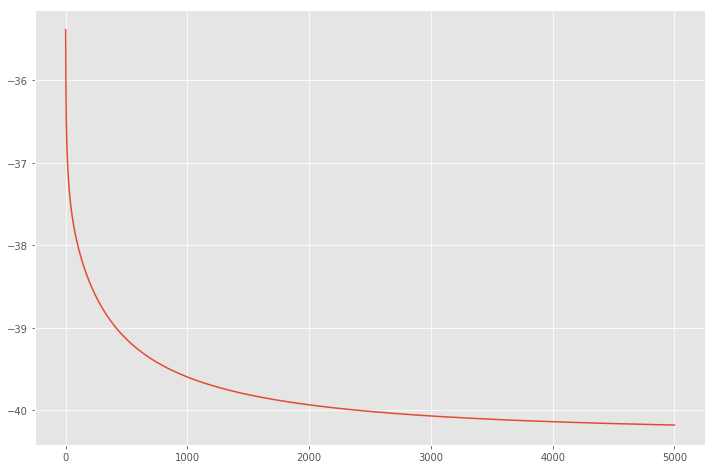

In [33]:
plt.plot(losses)

In [34]:
print('Training Accuracy:', accuracy(X_train, Y_train))
print('Validation Accuracy:', accuracy(X_val, Y_val))

Training Accuracy: 0.37495
Validation Accuracy: 0.2781


In [35]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix
[[5106  281  239  242  139  104   80  194  700  993]
 [ 896 2934  363  489  207  234  196  380  522 1805]
 [1489  319 2581  873  627  443  508  367  447  379]
 [ 636  346 1001 2851  656  745  613  307  363  549]
 [ 775  246 1051  978 2341  532  517  678  231  610]
 [ 802  364  969 1357  826 1811  524  475  408  512]
 [ 391  248 1006 1732  635  591 2563  288  189  312]
 [ 856  339  555  633  828  393  240 3097  187  846]
 [2047  394  384  414  208  212  135  159 2675 1368]
 [1065  893  266  315  165  155  205  352  411 4037]]


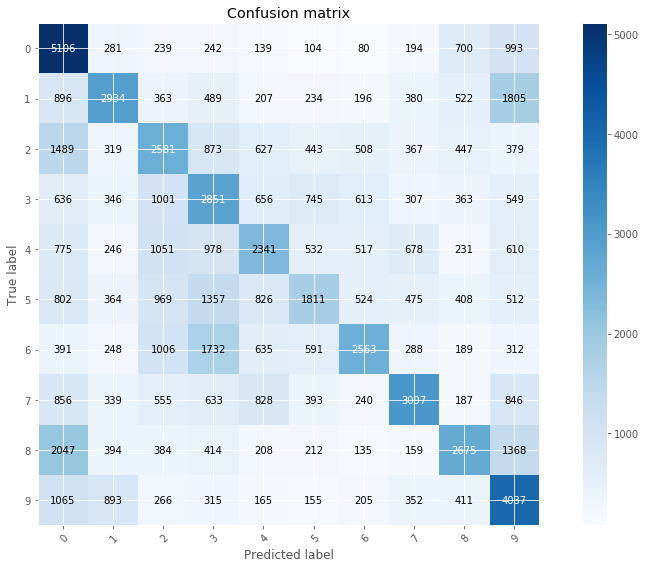

In [36]:
plot_confusion_matrix(Y_train, ProbsAndPreds(X_train)[1], np.unique(Y_train),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

# Neural Network with 1 Hidden Layer

In [104]:
train = np.load('./mini_cinic10/train.npz')
val = np.load('./mini_cinic10/val.npz')

In [105]:
X_train_norm = normalize(train['xs'], train['xs'].mean(), train['xs'].std()) 
X_val_norm = normalize(val['xs'], val['xs'].mean(), val['xs'].std()) 

In [106]:
X_train_norm.shape # 80k samples 3072 features

(80000, 3072)

In [158]:
# Samples
num_samples = 800

In [159]:
# Input Vector
a1 = X_train_norm.T[:,:num_samples]

In [160]:
# Target Vector
y = train['ys']
y = OneHotEncoding(y).T[:, :num_samples]

In [161]:
# Validation Data
val_a1 = X_val_norm.T[:,:num_samples]
val_y = val['ys'][:num_samples]
val_y = OneHotEncoding(val_y).T

In [162]:
# Toy Dataset
if False:
    bits = 5
    num_samples=2**bits+1
    entry = []
    answ = []
    for i in range(2**(bits+1)):
        bit = format(i, "#0{}b".format(bits+3)).replace("0b", "")
        data_i = []
        resp = True
        for c in bit:
            data_i.append(int(c))
            resp = resp and bool(int(c))
        entry.append(data_i)
        answ.append(int(resp))
        
    X_train_norm = np.array(entry)
    a1 = X_train_norm.T[:,:num_samples]
    y = np.array(answ)
    y = OneHotEncoding(y).T[:,:num_samples]
    val_a1 = a1.copy()
    val_y = y.copy()

In [163]:
def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return (x > 0).astype(int)

def xent(out, y):
    return -np.sum(y*log(out))

def sm(x):
    exps = np.exp(x - np.max(x))
    return exps/np.sum(exps)

def accur(out, y):
    yf = y.T
    outf = out.T
    m = len(yf)
    
    correct = 0
    for i in range(m):
        correct += (outf[i] == yf[0]).all().astype(int)
    return correct/m

In [170]:
# Parameters
EPOCH= 500
SEED=42
HIDDEN_NODES=300
LEARNING_RATE=0.1

# GD modes
SGD = False         # SGD == False -> Mini-Batch mode
MINI_BATCH_SIZE=100 # MINI_BATCH_SIZE = num_samples AND Mini-Batch mode -> Vanilla mode

# Optmizers
MOMENTUM = False
GAMMA = 0.9
ADAGRAD = False

In [171]:
# Main Loop
np.random.seed(SEED)

# Theta
# Theta1 = from input to hidden layer
num_features = a1.shape[0]
num_hidden_layers = HIDDEN_NODES
theta1 = np.random.randn(num_hidden_layers, num_features)

#Theta2 = From Hidden Layer to output layer
num_classes = y.shape[0]
theta2 = np.random.randn(num_classes, num_hidden_layers)

# Bias
b1 = np.random.randn(num_hidden_layers, 1)
b2 = np.random.randn(num_classes, 1)

# Optimizers
gamma = GAMMA
speed1 = np.zeros((num_hidden_layers, num_features))
speed2 = np.zeros((num_classes, num_hidden_layers))

cache1 = np.zeros((num_hidden_layers, num_features))
cache2 = np.zeros((num_classes, num_hidden_layers))

# Learning Rate
lr = LEARNING_RATE

# Cost Function History
train_c = []
val_c = []

# Mini-Batch Setup
epochs = EPOCH
if SGD:
    mb_size = 1
    iterations = num_samples
else:
    mb_size = MINI_BATCH_SIZE
    iterations = y.shape[1]//mb_size-1

start_time = time.time()
for i in range(epochs):
    for j in range(0, iterations+mb_size, mb_size):
        if SGD:
            rand_idx = np.random.randint(0, num_samples)
            mb_a1 = a1[:,rand_idx]
            mb_y = y[:,rand_idx]
            mb_a1.shape = (mb_a1.shape[0], 1)
            mb_y.shape = (mb_y.shape[0], 1)
        else:
            mb_a1 = a1[:, j:j+mb_size]
            mb_y = y[:, j:j+mb_size]
            
        # Forwarding
        z2 = theta1.dot(mb_a1)+b1
        a2 = relu(z2)
        z3 = theta2.dot(a2)+b2
        a3 = sm(z3)

        # Backpropagation
        delta_3 = a3 - mb_y
        delta_2 = theta2.T.dot(delta_3) * drelu(z2)

        # Gradient
        C_theta2 = delta_3.dot(a2.T)/num_samples
        C_theta1 = delta_2.dot(mb_a1.T)/num_samples

        # Learn
        if MOMENTUM:
            speed1 = gamma * speed1 + lr * C_theta1
            speed2 = gamma * speed2 + lr * C_theta2
            
            new_t1 = speed1
            new_t2 = speed2
            
        elif ADAGRAD:
            cache1 = cache1 + C_theta1**2
            cache2 = cache2 + C_theta2**2
            
            new_t1 = lr * C_theta1 / np.sqrt(cache1+10**-9)
            new_t2 = lr * C_theta2 / np.sqrt(cache2+10**-9)
            
        else:
            new_t1 = lr * C_theta1
            new_t2 = lr * C_theta2
            
        theta1 = theta1 - new_t1
        theta2 = theta2 - new_t2

        b2 = b2 - lr * np.sum(delta_3, axis=1, keepdims=True)/num_samples
        b1 = b1 - lr * np.sum(delta_2, axis=1, keepdims=True)/num_samples
        
    # Cost Function
    z2 = theta1.dot(a1)+b1
    a2 = relu(z2)
    z3 = theta2.dot(a2)+b2
    a3 = sm(z3)
    train_c.append(xent(a3, y))

    val_z2 = theta1.dot(val_a1)+b1
    val_a2 = relu(val_z2)
    val_z3 = theta2.dot(val_a2)+b2
    val_a3 = sm(val_z3)
    val_c.append(xent(val_a3, val_y))

    if (i % (epochs/10) == 0):
        print("{}%".format(i*100/epochs))
total_time = time.time() - start_time
print("Trainned in {} seconds".format(total_time))
print("Train Accuracy: {}%".format(100*accur(a3, y)))
print("Train Accuracy: {}%".format(100*accur(val_a3, val_y)))

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Trainned in 96.68691897392273 seconds
Train Accuracy: 0.0%
Train Accuracy: 0.0%


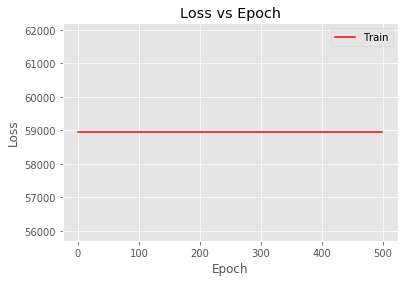

In [172]:
plt.plot(train_c, "r")
plt.plot(val_c, "b")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend(("Train","Validation"))
plt.savefig("loss.eps")

# Neural Network with 2 Hidden Layer

In [11]:
train = np.load('./mini_cinic10/train.npz')
val = np.load('./mini_cinic10/val.npz')

In [12]:
X_train_norm = normalize(train['xs'], train['xs'].mean(), train['xs'].std()) 
X_val_norm = normalize(val['xs'], val['xs'].mean(), val['xs'].std()) 

In [13]:
X_train_norm.shape # 80k samples 3072 features

(80000, 3072)

In [14]:
# Samples
num_samples = 80000

In [15]:
# Input Vector
a1 = X_train_norm.T[:,:num_samples]

In [16]:
# Target Vector
y = train['ys']
y = OneHotEncoding(y).T[:, :num_samples]

In [17]:
# Validation Data
val_a1 = X_val_norm.T[:,:num_samples]
val_y = val['ys'][:num_samples]
val_y = OneHotEncoding(val_y).T

In [19]:
# Toy Dataset
if False:
    bits = 5
    num_samples=2**bits+1
    entry = []
    answ = []
    for i in range(2**(bits+1)):
        bit = format(i, "#0{}b".format(bits+3)).replace("0b", "")
        data_i = []
        resp = True
        for c in bit:
            data_i.append(int(c))
            resp = resp and bool(int(c))
        entry.append(data_i)
        answ.append(int(resp))
        
    X_train_norm = np.array(entry)
    a1 = X_train_norm.T[:,:num_samples]
    y = np.array(answ)
    y = OneHotEncoding(y).T[:,:num_samples]
    val_a1 = a1.copy()
    val_y = y.copy()

In [107]:
# Parameters
EPOCH= 45
SEED=42
HIDDEN_NODES1=10
HIDDEN_NODES2=10
LEARNING_RATE=0.001

# GD modes
SGD = False         # SGD == False -> Mini-Batch mode
MINI_BATCH_SIZE=800 # MINI_BATCH_SIZE = num_samples AND Mini-Batch mode -> Vanilla mode

# Optmizers
MOMENTUM = False
GAMMA = 0.9
ADAGRAD = False

In [108]:
# Main Loop
np.random.seed(SEED)

# Theta
# Theta1 = from input to hidden layer
num_features = a1.shape[0]
num_hidden_layers1 = HIDDEN_NODES1
theta1 = np.random.randn(num_hidden_layers1, num_features)

#Theta2 = From Hidden Layer 1 to Hidden Layer 2
num_hidden_layers2 = HIDDEN_NODES2
theta2 = np.random.randn(num_hidden_layers2, num_hidden_layers1)

#Theta3 = From Hidden Layer 2 to output layer
num_classes = y.shape[0]
theta3 = np.random.randn(num_classes, num_hidden_layers2)

# Bias
b1 = np.random.randn(num_hidden_layers1, 1)
b2 = np.random.randn(num_hidden_layers2, 1)
b3 = np.random.randn(num_classes, 1)

# Optimizers
gamma = GAMMA
speed1 = np.zeros((num_hidden_layers1, num_features))
speed2 = np.zeros((num_hidden_layers2, num_hidden_layers1))
speed3 = np.zeros((num_classes, num_hidden_layers2))

cache1 = np.zeros((num_hidden_layers1, num_features))
cache2 = np.zeros((num_hidden_layers2, num_hidden_layers1))
cache3 = np.zeros((num_classes, num_hidden_layers2))

# Learning Rate
lr = LEARNING_RATE

# Cost Function History
train_c = []
val_c = []

# Mini-Batch Setup
epochs = EPOCH
if SGD:
    mb_size = 1
    iterations = num_samples
else:
    mb_size = MINI_BATCH_SIZE
    iterations = y.shape[1]//mb_size

start_time = time.time()
for i in range(epochs):
    for j in range(0, iterations+mb_size, mb_size):
        if SGD:
            rand_idx = np.random.randint(0, num_samples)
            mb_a1 = a1[:,rand_idx]
            mb_y = y[:,rand_idx]
            mb_a1.shape = (mb_a1.shape[0], 1)
            mb_y.shape = (mb_y.shape[0], 1)
        else:
            mb_a1 = a1[:, j:j+mb_size]
            mb_y = y[:, j:j+mb_size]
        
        # Forwarding
        z2 = theta1.dot(mb_a1)+b1
        a2 = relu(z2)
        z3 = theta2.dot(a2)+b2
        a3 = relu(z3)
        z4 = theta3.dot(a3)+b3
        a4 = sm(z4)

        # Backpropagation
        delta_4 = a4 - mb_y
        delta_3 = theta3.T.dot(delta_4) * drelu(z3)
        delta_2 = theta2.T.dot(delta_3) * drelu(z2)

        # Gradient
        C_theta3 = delta_4.dot(a3.T)/num_samples
        C_theta2 = delta_3.dot(a2.T)/num_samples
        C_theta1 = delta_2.dot(mb_a1.T)/num_samples

        # Learn
        if MOMENTUM:
            speed1 = gamma * speed1 + lr * C_theta1
            speed2 = gamma * speed2 + lr * C_theta2
            speed3 = gamma * speed3 + lr * C_theta3
            
            new_t1 = speed1
            new_t2 = speed2
            new_t3 = speed3
            
        elif ADAGRAD:
            cache1 = cache1 + C_theta1**2
            cache2 = cache2 + C_theta2**2
            cache3 = cache3 + C_theta3**2
            
            new_t1 = lr * C_theta1 / np.sqrt(cache1+10**-9)
            new_t2 = lr * C_theta2 / np.sqrt(cache2+10**-9)
            new_t3 = lr * C_theta3 / np.sqrt(cache3+10**-9)
            
        else:
            new_t1 = lr * C_theta1
            new_t2 = lr * C_theta2
            new_t3 = lr * C_theta3
        
        theta1 = theta1 - new_t1
        theta2 = theta2 - new_t2
        theta3 = theta3 - new_t3

        b3 = b3 - lr * np.sum(delta_4, axis=1, keepdims=True)/num_samples
        b2 = b2 - lr * np.sum(delta_3, axis=1, keepdims=True)/num_samples
        b1 = b1 - lr * np.sum(delta_2, axis=1, keepdims=True)/num_samples
        
    # Cost Function
    z2 = theta1.dot(a1)+b1
    a2 = relu(z2)
    z3 = theta2.dot(a2)+b2
    a3 = relu(z3)
    z4 = theta3.dot(a3)+b3
    a4 = sm(z4)
    train_c.append(xent(a4, y))

    val_z2 = theta1.dot(val_a1)+b1
    val_a2 = relu(val_z2)
    val_z3 = theta2.dot(val_a2)+b2
    val_a3 = relu(val_z3)
    val_z4 = theta3.dot(val_a3)+b3
    val_a4 = sm(val_z4)
    val_c.append(xent(val_a4, val_y))

    if (i % (epochs/10) == 0):
        print("{}%".format(i*100/epochs))
total_time = time.time() - start_time
print("Trainned in {} seconds".format(total_time))
print("Train Accuracy: {}%".format(100*accur(a4, y)))
print("Train Accuracy: {}%".format(100*accur(val_a4, val_y)))

0.0%
20.0%
40.0%
60.0%
80.0%
Trainned in 33.65505242347717 seconds


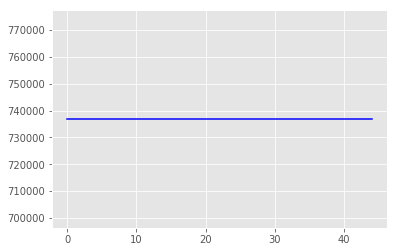

In [111]:
plt.plot(train_c, "r")
plt.plot(val_c, "b")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend(("Train","Validation"))
plt.savefig("loss.eps")